# Setup

In [8]:
!python -m pip install gurobi-optimods
!pip install catboost
!pip install SALib

from sklearn import datasets
from sklearn.model_selection import train_test_split

from gurobi_optimods.regression import LADRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

from SALib.analyze import sobol
import numpy as np
import SALib
from SALib.sample import latin
from SALib.analyze import pawn


import matplotlib.pyplot as plt
import sklearn

In [9]:
# Used for styling of graphs
!pip install SciencePlots

import scienceplots
plt.style.use(['science', 'grid', 'no-latex'])

# Data

In [10]:
# Loads the diabetes dataset
diabetes = datasets.load_diabetes()

# Splits data for fit assessment
xTrain, xTest, yTrain, yTest = train_test_split(
    diabetes["data"], diabetes["target"], random_state=42
)

# Sensitivity analysis

In [11]:
# Perform the analysis using the CatBoostRegressor
reg = CatBoostRegressor(iterations=250, learning_rate=1, depth=8, silent=True)
reg.fit(xTrain, yTrain)


# Define the parameters for the Sobol sensitivity analysis
problem = {
    'num_vars': xTrain.shape[1],
    'names': ['feature_{}'.format(i) for i in range(xTrain.shape[1])],
    'bounds': [(0, 1)] * xTrain.shape[1]
}

X = latin.sample(problem, 1000)
Y = reg.predict(X)

Si = SALib.analyze.pawn.analyze(problem, X, Y, S=10, print_to_console=False)

In [12]:
Si

{'minimum': array([0.031     , 0.044     , 0.07258586, 0.049     , 0.053     ,
        0.095     , 0.058     , 0.068     , 0.036     , 0.07339394]),
 'mean': array([0.1167798 , 0.06976364, 0.12485859, 0.10186465, 0.10257374,
        0.1828    , 0.12060707, 0.18593838, 0.09128182, 0.10743939]),
 'median': array([0.085     , 0.06881818, 0.0895    , 0.07632323, 0.0795    ,
        0.1155    , 0.083     , 0.14      , 0.069     , 0.087     ]),
 'maximum': array([0.415, 0.095, 0.445, 0.364, 0.28 , 0.81 , 0.381, 0.636, 0.287,
        0.282]),
 'CV': array([0.88029658, 0.21610057, 0.86263214, 0.86863488, 0.60799198,
        1.14531827, 0.78548395, 0.8413547 , 0.75074823, 0.5519119 ]),
 'names': ['feature_0',
  'feature_1',
  'feature_2',
  'feature_3',
  'feature_4',
  'feature_5',
  'feature_6',
  'feature_7',
  'feature_8',
  'feature_9']}

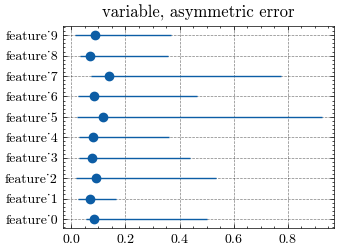

In [14]:
lowerError = Si['minimum']
upperError = Si['maximum']
asymmetricError = [lowerError, upperError]

plt.errorbar(Si['median'], Si['names'], xerr=asymmetricError, fmt='o')
plt.title('variable, asymmetric error')
plt.show()